### Ethereum Trader Strategy
dataset = https://www.kaggle.com/datasets/kaushiksuresh147/ethereum-cryptocurrency-historical-dataset\
Also not financial advice, for educational purposes only.

The main objective of this analysis is to explore the Classification techniques learned throughout the Supervised Machine Learning course. In this project, I want to predict the buy/sell signal of ethereum depending on a certain event, if the data lines up perfectly for either a bear or bull movement. Note that none of this is considered financial advice and for educational purposes only. I will not be responsible for anyone's losses or gains from any part of my project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Ethereum Historical Data.csv', index_col=False)
df

Date     Open     High      Low    Close   Volume
0     2016-03-10    11.20    11.85    11.07    11.75        4
1     2016-03-11    11.75    11.95    11.75    11.95      179
2     2016-03-12    11.95    13.45    11.95    12.92      833
3     2016-03-13    12.92    15.07    12.92    15.07     1295
4     2016-03-14    15.07    15.07    11.40    12.50    92183
...          ...      ...      ...      ...      ...      ...
2376  2022-09-11  1774.38  1786.73  1722.62  1766.93   467415
2377  2022-09-12  1766.99  1782.74  1694.08  1716.42   727783
2378  2022-09-13  1716.45  1751.50  1562.30  1574.47  1304668
2379  2022-09-14  1574.41  1646.09  1556.97  1637.92   858277
2380  2022-09-15  1637.89  1653.55  1573.00  1590.58  1391957

[2381 rows x 6 columns]

Using the ethereum dataset from my IBM linear regression project and convert it to a classification problem. I will add a buy/sell signal for a binary classification and identify the best ML algorithm to make a good prediction.

Again, I will remove the 'Date' for this project. I would most likely use time series with this dataset, but since the project requests a classification technique, I will remove it for simplicity.

In [4]:
df = df.drop('Date',axis=1)

In [5]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

I am going to add some basic feature that has high relevance, based on professional traders... I will find out whether or not it will be useful for the classification or not later.

#### Feature Engineer: Moving Averages(MA), Relative Strength Index (RSI), MACD 12-26-9, and Momentum

Moving Average is an important indicator that smoothens out price data that removing noise in the 
series, rolled back on the number of specified days (in this project, it’s 7/50/100 days). 
\
\
Exponential Moving Average is weighted moving average that gives more weights to the Close price, similar to MA. 
\
\
Relative Strength Index is a momentum indicator that measures the magnitude of the security’s recent 
price change and evaluate overbought or oversold conditions. 
\
\
Moving Average Convergence Divergence shows the relationship between two EMA of a security price. 
\
\
Momentum is described as the rate of acceleration at which price is changing.

In [6]:
def MA(df): # Moving Average of 7,50,100 days
    df['MA_7days'] = df.iloc[:,3].rolling(window=7).mean()
    df['MA_50days'] = df.iloc[:,3].rolling(window=50).mean()
    df['MA_100days'] = df.iloc[:,3].rolling(window=100).mean()
MA(df)

In [7]:
def EMA(df): # Exponential Moving Average of 7,50,100 days
    df['EMA_7days'] = df['Close'].ewm(span=7,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()
EMA(df)

In [8]:
def RSIs(df,n): # Relative Strength Index
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=(n-1), adjust=False).mean()
    ema_neg = df['neg'].ewm(com=(n-1), adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'+str(n)] = 100-(100/(1+relative_str))
RSIs(df, 7)
RSIs(df, 50)
RSIs(df, 100)

In [9]:
def MACD(df): # Moving Average Convergence Divergence... default is 12-26-9
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1-exp2
MACD(df)

In [10]:
def MOM(df,n): #Momentum over 7,50,100 days
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM7'] = MOM(df['Close'], 7)
df['MOM50'] = MOM(df['Close'], 50)
df['MOM100'] = MOM(df['Close'], 100)

In [11]:
# 0 = short term price will go down compared to long term
# 1 = short term price will go up compared to long term
def signal(df):
    sma = df['Close'].rolling(window=10, min_periods=1, center=False).mean()
    lma = df['Close'].rolling(window=60, min_periods=1, center=False).mean()
    df['signal'] = np.where(sma > lma, 1.0, 0.0)
signal(df)

In [12]:
df = df.drop(['diff','pos','neg','High','Low', 'Open'],axis=1)

In [13]:
df.shape

(2381, 16)

In [14]:
df.head(5)

Close  Volume  MA_7days  MA_50days  MA_100days  EMA_7days  EMA_50days  \
0  11.75       4       NaN        NaN         NaN  11.750000   11.750000   
1  11.95     179       NaN        NaN         NaN  11.800000   11.757843   
2  12.92     833       NaN        NaN         NaN  12.080000   11.803418   
3  15.07    1295       NaN        NaN         NaN  12.827500   11.931519   
4  12.50   92183       NaN        NaN         NaN  12.745625   11.953813   

   EMA_100days        RSI7       RSI50      RSI100      MACD  MOM7  MOM50  \
0    11.750000         NaN         NaN         NaN  0.000000   NaN    NaN   
1    11.753960  100.000000  100.000000  100.000000  0.015954   NaN    NaN   
2    11.777050  100.000000  100.000000  100.000000  0.105651   NaN    NaN   
3    11.842257  100.000000  100.000000  100.000000  0.346233   NaN    NaN   
4    11.855282   57.217598   82.890059   89.742639  0.325763   NaN    NaN   

   MOM100  signal  
0     NaN     0.0  
1     NaN     0.0  
2     NaN     0.0  
3     NaN     0.0  
4     NaN     0.0

There's NaN in the beginning because with the rolling feature, it calculates the previous value days for the custom features' (MA, EMA, RSI, MOM) 7/50/100 day period.

In [15]:
df.tail(5)

Close   Volume     MA_7days  MA_50days  MA_100days    EMA_7days  \
2376  1766.93   467415  1671.342857  1672.1946   1488.4306  1690.856876   
2377  1716.42   727783  1685.535714  1674.5592   1487.5511  1697.247657   
2378  1574.47  1304668  1687.910000  1677.2782   1485.2287  1666.553243   
2379  1637.92   858277  1689.111429  1681.0226   1483.0080  1659.394932   
2380  1590.58  1391957  1682.787143  1680.1140   1480.7766  1642.191199   

       EMA_50days  EMA_100days       RSI7      RSI50     RSI100       MACD  \
2376  1627.680595  1704.228323  71.748089  51.167649  48.210868  16.552587   
2377  1631.160572  1704.469742  59.911673  50.262124  47.854084  19.910055   
2378  1628.937412  1701.895490  38.881032  47.834516  46.869454  10.990009   
2379  1629.289670  1700.628648  48.338062  48.958934  47.358493   8.937665   
2380  1627.771644  1698.449467  42.600389  48.168478  47.032239   3.451439   

        MOM7   MOM50  MOM100  signal  
2376  188.04  217.32   -8.36     1.0  
2377   99.35  118.23  -87.95     1.0  
2378   16.62  135.95 -232.24     1.0  
2379    8.41  187.22 -222.07     1.0  
2380  -44.27  -45.43 -223.14     1.0

No NaN at the tail, I can confirm the data matches with the period of Ethereum's price timeline between 2016 and 2022. (This was before the feature engineering and date removal)

### Data Cleaning

In [16]:
df.isnull().sum()

Close            0
Volume           0
MA_7days         6
MA_50days       49
MA_100days      99
EMA_7days        0
EMA_50days       0
EMA_100days      0
RSI7             1
RSI50            1
RSI100           1
MACD             0
MOM7             7
MOM50           50
MOM100         100
signal           0
dtype: int64

To reiterate, it's best to drop the NaN values because we can't fill the missing values with SimpleImputer or their mean/median values; otherwise it introduce bias. Plus, I did feature engineer these features... and missing the first few months of data won't be the end of the world when I'm working with 6 years worth of ethereum data

In [17]:
df = df.dropna(axis=0)

### Exploratory Data Analysis EDA

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 100 to 2380
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        2281 non-null   float64
 1   Volume       2281 non-null   int64  
 2   MA_7days     2281 non-null   float64
 3   MA_50days    2281 non-null   float64
 4   MA_100days   2281 non-null   float64
 5   EMA_7days    2281 non-null   float64
 6   EMA_50days   2281 non-null   float64
 7   EMA_100days  2281 non-null   float64
 8   RSI7         2281 non-null   float64
 9   RSI50        2281 non-null   float64
 10  RSI100       2281 non-null   float64
 11  MACD         2281 non-null   float64
 12  MOM7         2281 non-null   float64
 13  MOM50        2281 non-null   float64
 14  MOM100       2281 non-null   float64
 15  signal       2281 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 302.9 KB


In [19]:
df.describe().T

count          mean           std          min            25%  \
Close        2281.0  8.926117e+02  1.158010e+03     6.700000     160.730000   
Volume       2281.0  1.312264e+07  1.030721e+08     0.000000  604785.000000   
MA_7days     2281.0  8.904754e+02  1.155773e+03     7.317143     161.225714   
MA_50days    2281.0  8.750034e+02  1.141196e+03     8.388200     159.084000   
MA_100days   2281.0  8.585676e+02  1.125037e+03     9.447700     163.807000   
EMA_7days    2281.0  8.904745e+02  1.154556e+03     7.335611     160.176087   
EMA_50days   2281.0  8.752720e+02  1.132915e+03     8.525090     162.756457   
EMA_100days  2281.0  8.560201e+02  1.107717e+03     9.502722     171.104730   
RSI7         2281.0  5.228939e+01  1.821615e+01     7.113555      39.301222   
RSI50        2281.0  5.215214e+01  8.721635e+00    33.347422      46.034447   
RSI100       2281.0  5.260153e+01  6.767774e+00    40.479369      47.683748   
MACD         2281.0  4.977322e+00  7.913735e+01  -322.862350     -10.807296   
MOM7         2281.0  5.111065e+00  1.837598e+02 -1642.270000     -20.830000   
MOM50        2281.0  3.655243e+01  5.012200e+02 -2011.080000     -53.620000   
MOM100       2281.0  6.441782e+01  6.438669e+02 -2482.540000     -91.810000   
signal       2281.0  5.466900e-01  4.979244e-01     0.000000       0.000000   

                      50%           75%           max  
Close        2.971900e+02  1.283700e+03  4.808380e+03  
Volume       1.524946e+06  7.903410e+06  1.792561e+09  
MA_7days     2.975571e+02  1.265267e+03  4.690374e+03  
MA_50days    2.859554e+02  1.293179e+03  4.359633e+03  
MA_100days   2.787973e+02  1.036285e+03  4.053609e+03  
EMA_7days    2.976040e+02  1.259483e+03  4.651187e+03  
EMA_50days   2.907541e+02  1.407846e+03  4.230935e+03  
EMA_100days  2.799557e+02  1.172209e+03  3.942851e+03  
RSI7         5.123567e+01  6.524838e+01  9.577951e+01  
RSI50        5.123979e+01  5.700366e+01  8.477758e+01  
RSI100       5.216217e+01  5.579558e+01  8.112398e+01  
MACD         4.143265e-01  1.777173e+01  4.548792e+02  
MOM7         7.000000e-01  2.982000e+01  9.719000e+02  
MOM50        9.490000e+00  1.467100e+02  2.488840e+03  
MOM100       1.763000e+01  1.726400e+02  2.855050e+03  
signal       1.000000e+00  1.000000e+00  1.000000e+00

### Visualization

array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'MA_7days'}>,
        <AxesSubplot:title={'center':'MA_50days'}>],
       [<AxesSubplot:title={'center':'MA_100days'}>,
        <AxesSubplot:title={'center':'EMA_7days'}>,
        <AxesSubplot:title={'center':'EMA_50days'}>,
        <AxesSubplot:title={'center':'EMA_100days'}>],
       [<AxesSubplot:title={'center':'RSI7'}>,
        <AxesSubplot:title={'center':'RSI50'}>,
        <AxesSubplot:title={'center':'RSI100'}>,
        <AxesSubplot:title={'center':'MACD'}>],
       [<AxesSubplot:title={'center':'MOM7'}>,
        <AxesSubplot:title={'center':'MOM50'}>,
        <AxesSubplot:title={'center':'MOM100'}>,
        <AxesSubplot:title={'center':'signal'}>]], dtype=object)

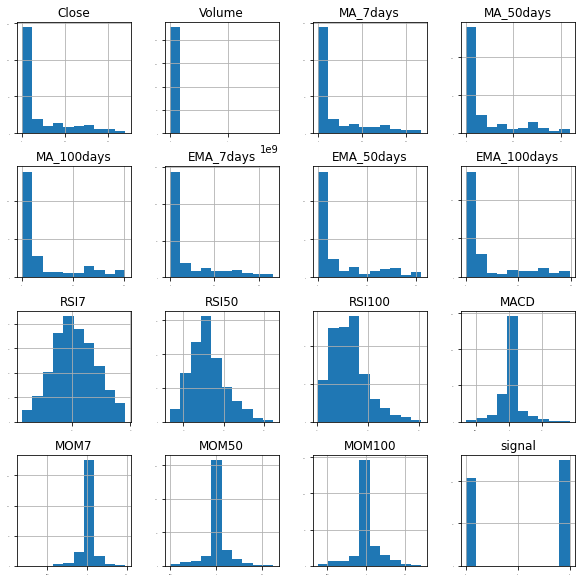

In [20]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(10,10))

<AxesSubplot:ylabel='signal'>

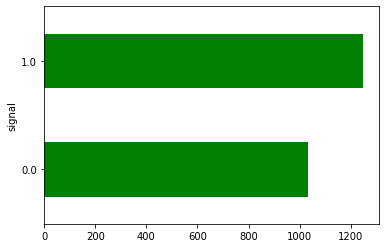

In [21]:
df.groupby(['signal']).size().plot(kind='barh',color='green')

In [22]:
df.shape[0]

2281

In [23]:
upticks = df['signal'].sum()
downticks = df.shape[0] - upticks
print(f'uptick: {upticks} ... downtick: {downticks}')

uptick: 1247.0 ... downtick: 1034.0


So we have 54.6% uptick signal between 2016-2022. Not bad, makes it stratified a bit.

#### Correlation

<AxesSubplot:title={'center':'Correlation Matrix'}>

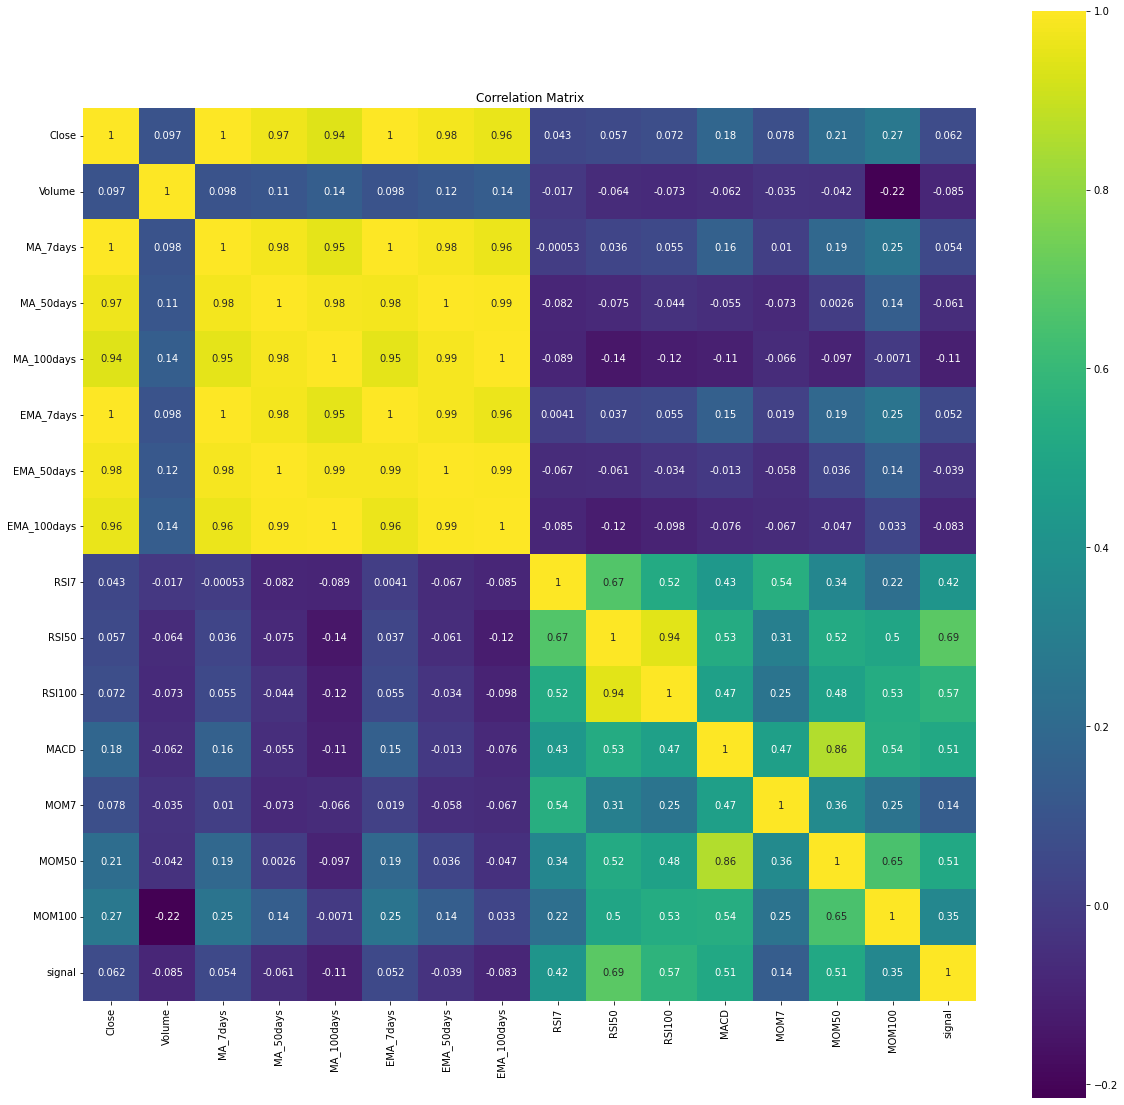

In [24]:
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), vmax=1, square=True, annot=True, cmap='viridis')

In [25]:
df.corr()['signal'].sort_values(ascending=False)

signal         1.000000
RSI50          0.690771
RSI100         0.568721
MACD           0.514145
MOM50          0.513246
RSI7           0.416810
MOM100         0.346410
MOM7           0.139032
Close          0.061511
MA_7days       0.053544
EMA_7days      0.051950
EMA_50days    -0.038970
MA_50days     -0.061222
EMA_100days   -0.083246
Volume        -0.084868
MA_100days    -0.109823
Name: signal, dtype: float64

Compared to the Linear Regression, we saw that the 'Close' price was highly correlated with the MA/EMA and correlation with the momentum, MACD, and volume. Here for the classification, we find the correlation behind the "buy/sell" intuition, where RSI, MACD, Momentum shows prominent Pearson Coefficient value. 

array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'MA_7days'}>,
        <AxesSubplot:title={'center':'MA_50days'}>],
       [<AxesSubplot:title={'center':'MA_100days'}>,
        <AxesSubplot:title={'center':'EMA_7days'}>,
        <AxesSubplot:title={'center':'EMA_50days'}>,
        <AxesSubplot:title={'center':'EMA_100days'}>],
       [<AxesSubplot:title={'center':'RSI7'}>,
        <AxesSubplot:title={'center':'RSI50'}>,
        <AxesSubplot:title={'center':'RSI100'}>,
        <AxesSubplot:title={'center':'MACD'}>],
       [<AxesSubplot:title={'center':'MOM7'}>,
        <AxesSubplot:title={'center':'MOM50'}>,
        <AxesSubplot:title={'center':'MOM100'}>,
        <AxesSubplot:title={'center':'signal'}>]], dtype=object)

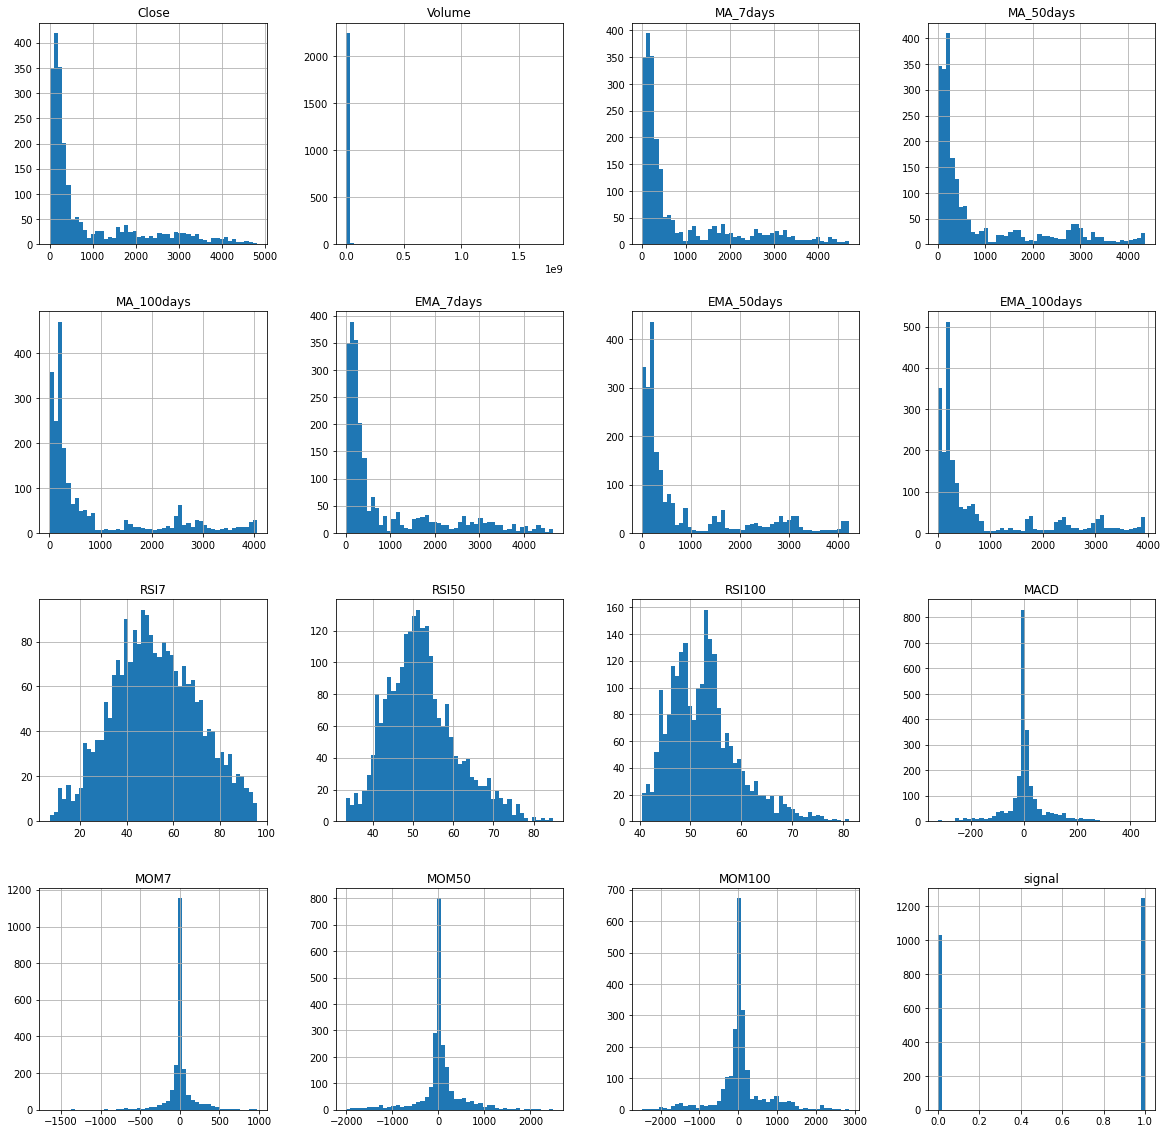

In [26]:
df.hist(bins=50, figsize=(20,20))

The volume data shows the volume transaction per day for Ethereum, where X axis is 1e9, which this current graph can't really support high volumes (Ethereum volume is over a million) given that the bin value is only at 50 to view the other features. I notice that the Moving Averages and Exponential Moving Average [7,50,100] days show a skew right data, where majority of the MA clusters on the left side and have a high variance spread. RSI-7 days follow a normal distribution, and as you increase the amount of days of RSI, the data becomes much more positively skewed, shown above with RSI[7,50,100]. The MACD and Momentum graph shows a tighter normal distribution with a low variance.

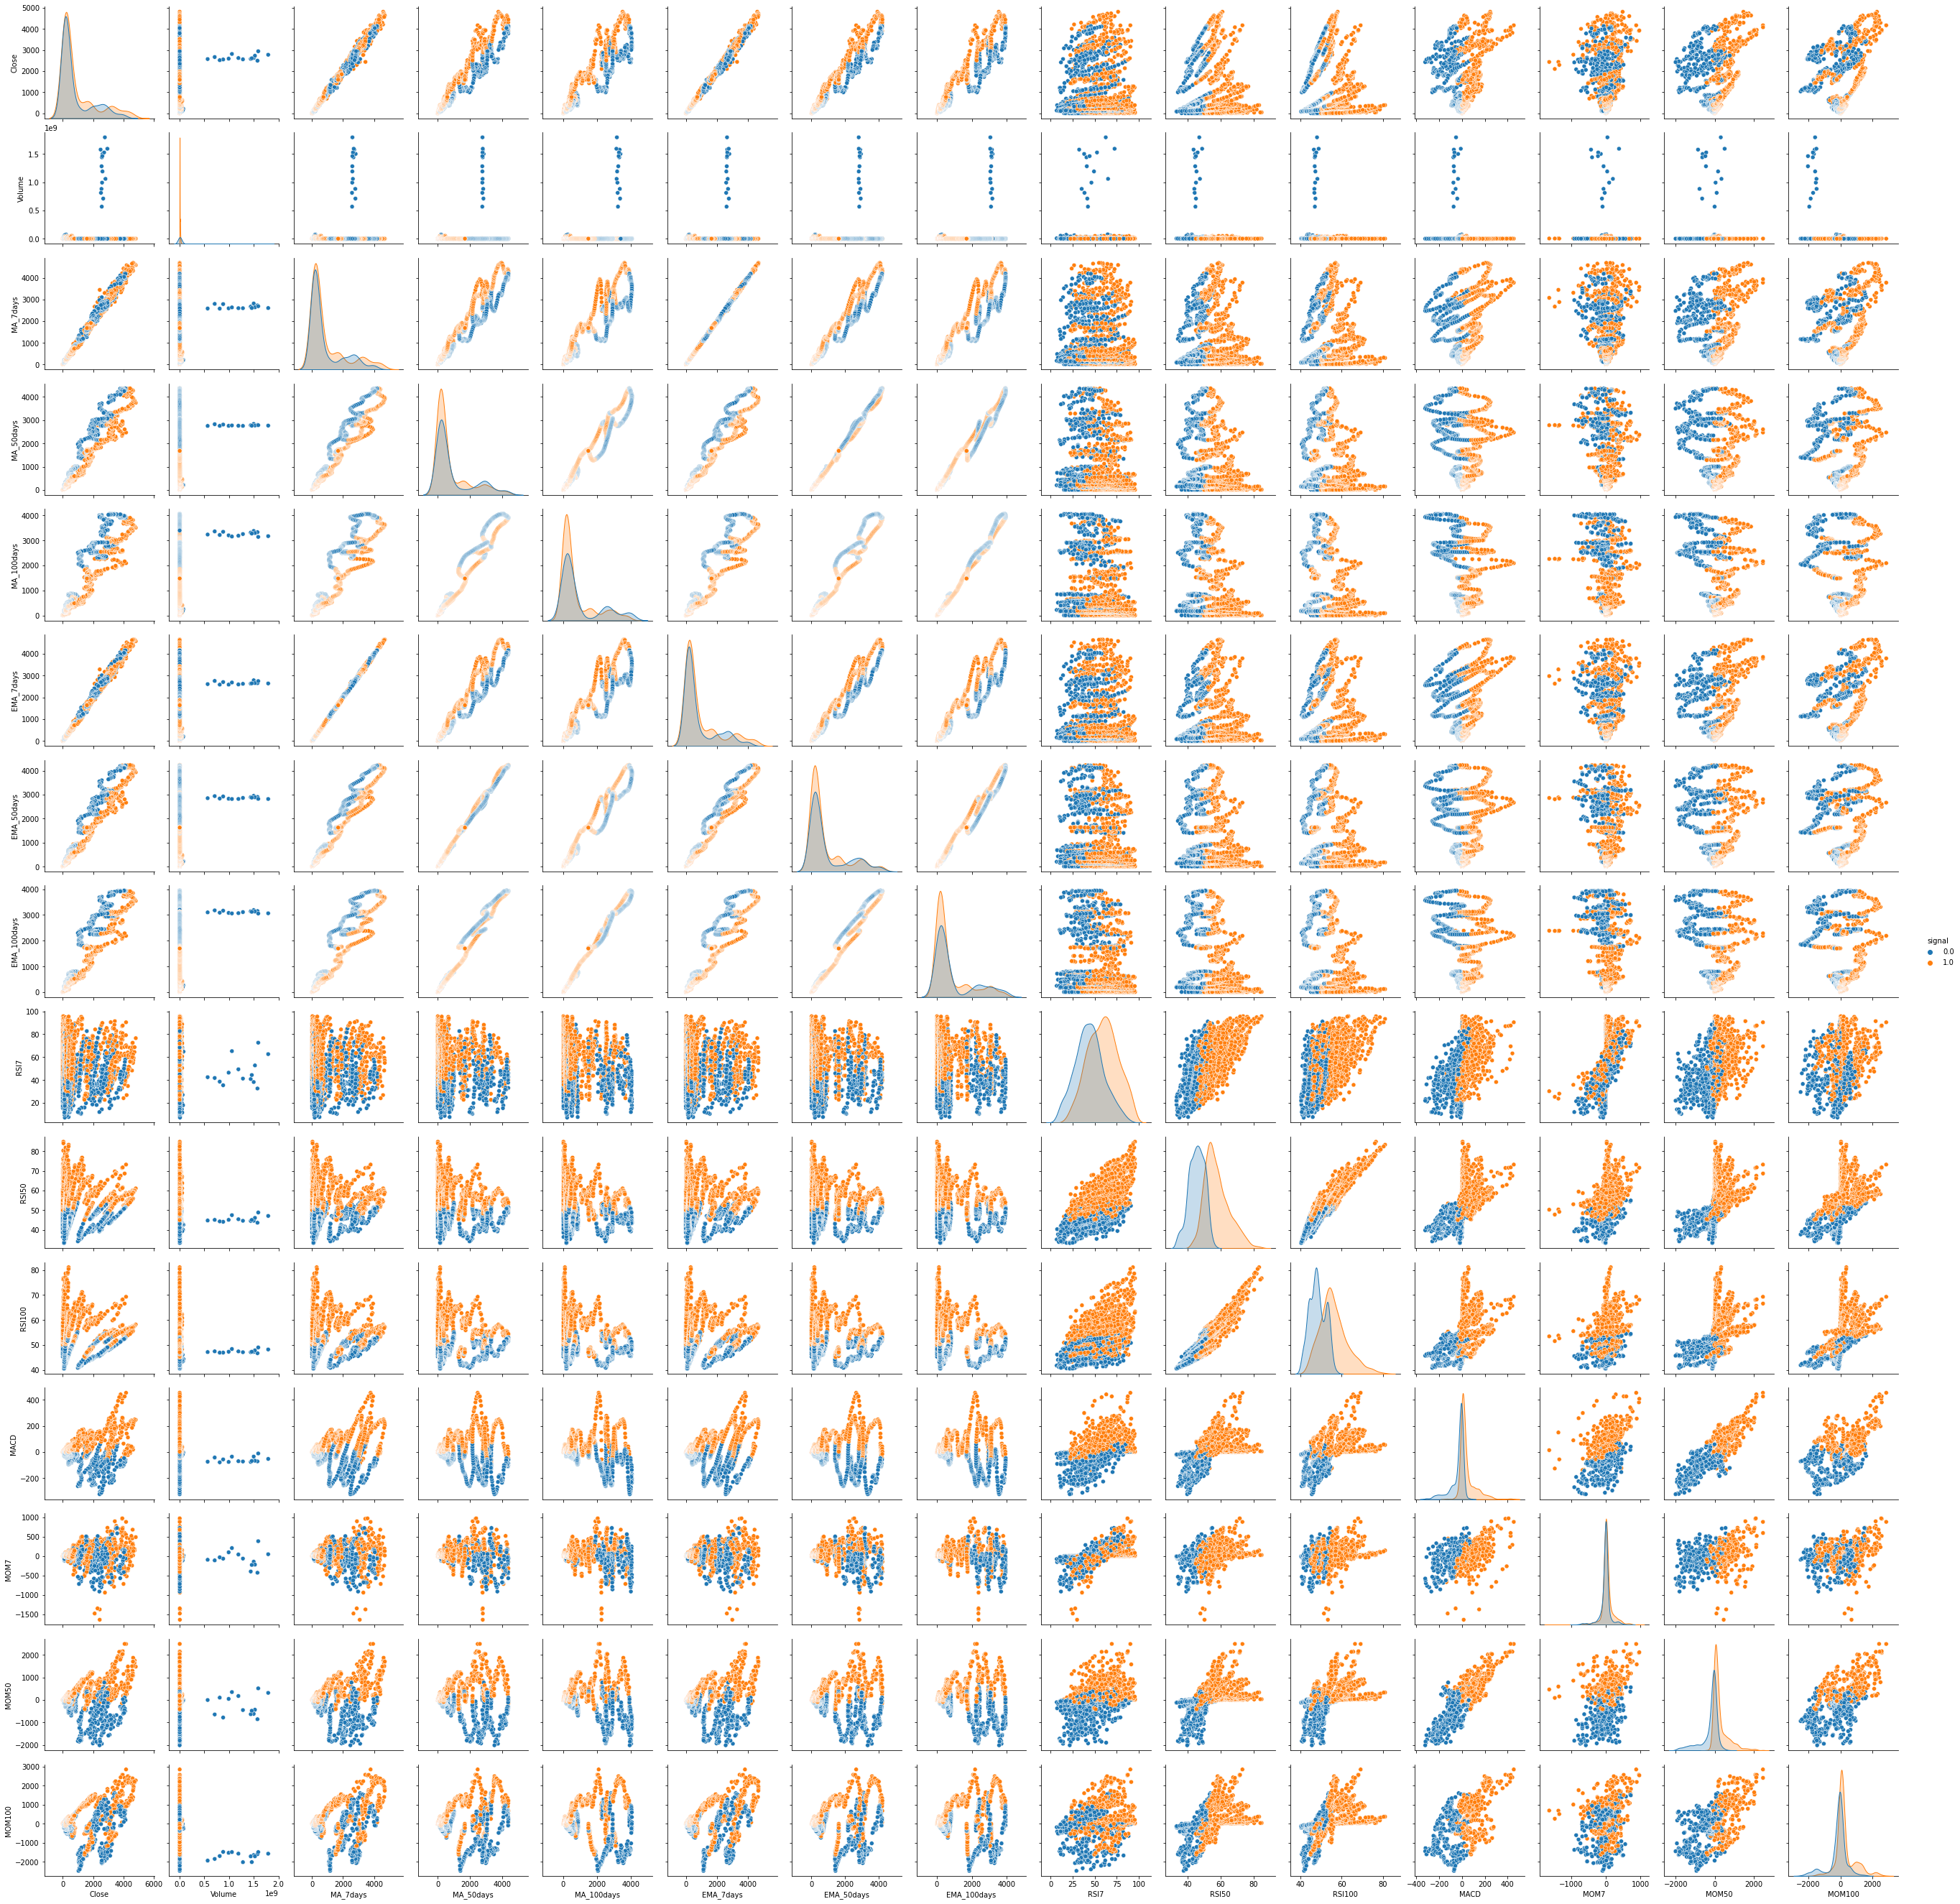

In [27]:
sns.pairplot(df, hue='signal')

In this pairplot, although the pattern may be strange, there is a clear segregation pattern between the uptick and downtick. Datapoints from the same type tends to cluster together. Although, this would probably be better represented in a 3D plot.

### Train Test Split

In [28]:
X = df.drop('signal',axis=1).values
y = df['signal'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
val_size = 0.2
val = int(df.shape[0]*0.8)
subset = df.iloc[-val:]

### Model Selection

Here we will select all the classification method from this course and identify the robust model for this classification problem

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

In [32]:
models = []
models.append(('LR',LogisticRegression(n_jobs=-1)))
models.append(('KNN',KNeighborsClassifier()))
models.append(('Lin_SVC', LinearSVC()))
models.append(('RBF_SVC', SVC(kernel='rbf',gamma=1, C=10)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GB',GradientBoostingClassifier()))
models.append(('RF',RandomForestClassifier()))


In [33]:
num_folds = 10

In [34]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.946765 (0.021347)
KNN: 0.934827 (0.019488)
Lin_SVC: 0.948652 (0.020847)
RBF_SVC: 0.961800 (0.015387)
CART: 0.958027 (0.020022)
AB: 0.953007 (0.021899)
GB: 0.961140 (0.018977)
RF: 0.965539 (0.014350)


### Top 3 model candidates: Gaussian Kernel SVC, Gradient Boost, Random Forest

#### Accuracy
RBF_SVC: 0.9618003144654088, (0.015387469586135008)\
GB: 0.9617688679245283, (0.018475797847653377)\
RF: 0.9642688679245282, (0.019675224483766643)

In [35]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.958926 (0.035507)
KNN: 0.938150 (0.033215)
Lin_SVC: 0.960249 (0.030559)
RBF_SVC: 0.963223 (0.016829)
CART: 0.959395 (0.023693)
AB: 0.959169 (0.024303)
GB: 0.962951 (0.026538)
RF: 0.967340 (0.023601)


#### Precision
RBF_SVC: 0.963223 (0.016829)\
GB: 0.962974 (0.026552)\
RF: 0.969809 (0.030180)

In [36]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.941060 (0.029981)
KNN: 0.938886 (0.013829)
Lin_SVC: 0.943496 (0.032561)
RBF_SVC: 0.965143 (0.021826)
CART: 0.961351 (0.023703)
AB: 0.951873 (0.029117)
GB: 0.964963 (0.018552)
RF: 0.970690 (0.011087)


#### Recall
RBF_SVC: 0.965143 (0.021826)\
GB: 0.964963 (0.018552)\
RF: 0.970786 (0.018850)

In [37]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.991636 (0.007137)
KNN: 0.981500 (0.011506)
Lin_SVC: 0.992701 (0.007234)
RBF_SVC: 0.990869 (0.006516)
CART: 0.954799 (0.019537)
AB: 0.986405 (0.011755)
GB: 0.992561 (0.006432)
RF: 0.995211 (0.005299)


#### ROC AUC

Lin_SVC: 0.992701 (0.007240)\
GB: 0.992547 (0.006619)\
RF: 0.995770 (0.004376)

The other models were all great candidates for this type of classification, most of them were above 95% accuracy except K-Nearest, Logistic Regression, Linear SVC; nonetheless they are still good candidates, but having high degree of accuracy is always better. 

In [38]:
cv_eval = {'Models':['Gaussian Kernel SVC', 'Gradient Boost','Random Forest'],
        'Accuracy':[0.9618,0.961769,0.965539],
        'Precision':[0.963223,0.962974,0.969809],
        'Recall':[0.965143,0.964963,0.970786],
        'ROC AUC':[0.990869,0.992547,0.99577]}
df1 = pd.DataFrame(cv_eval)
df1 = df1.set_index('Models')

In [39]:
df1

Accuracy  Precision    Recall   ROC AUC
Models                                                      
Gaussian Kernel SVC  0.961800   0.963223  0.965143  0.990869
Gradient Boost       0.961769   0.962974  0.964963  0.992547
Random Forest        0.965539   0.969809  0.970786  0.995770

The Overall score for Random Forest is overall better in the cross validation in the 4 listed metrics. We will proceed with Random Forest as the best algorithm to proceed fitting our training set.

In [40]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


### Grid Search CV

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
n_estimators = [20,80]
max_depth=[5,10]
criterion = ['gini','entropy']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_scaled, y_train)

In [43]:
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print('#%d %f (%f) with %r' % (rank, mean, stdev, param))

Best: 0.965539 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#8 0.937948 (0.023754) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.943593 (0.023840) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#1 0.965539 (0.016866) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.965535 (0.015416) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.938589 (0.019416) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.944214 (0.021839) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.961781 (0.012663) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.964292 (0.016571) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


Here we find that that the best value/parameter of the Random Forest Classifier: Entropy - Max_depth=10, n_estimator=80

### Finalizing the model

In [44]:
rf = RandomForestClassifier(criterion='entropy',max_depth=10, n_estimators=80)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [46]:
print(accuracy_score(y_test, predictions))

0.9547445255474453


In [47]:
print(confusion_matrix(y_test, predictions))

[[281  15]
 [ 16 373]]


In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       296
         1.0       0.96      0.96      0.96       389

    accuracy                           0.95       685
   macro avg       0.95      0.95      0.95       685
weighted avg       0.95      0.95      0.95       685



The model predicted well in both the training set and the cross validation. I even applied it with the Grid Search and having it yield 96% accuracy means that the model is fitted well. However, I know for a fact that market doesn't behave good as this model, which is why I did not introduce other custom features, but for a logistic regression; however, it performed decently than I expected. It's great to see the signaling working that indicates the buy/sell signal to allow traders to formulate their own financial decision on whether to get in the securities or back off, especially if it's a volitile one.